In [36]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e11/sample_submission.csv
/kaggle/input/playground-series-s5e11/train.csv
/kaggle/input/playground-series-s5e11/test.csv


In [37]:
# ================================================================
# Import Libraries 
# ================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # Plotting library
import seaborn as sns # Statistical plots built on matplotlib
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score

In [38]:
# ================================================================
# Load Data
# ================================================================
train_df = pd.read_csv("/kaggle/input/playground-series-s5e11/train.csv")
test_df = pd.read_csv("/kaggle/input/playground-series-s5e11/test.csv")



In [ ]:
# ================================================================
# Feature Engineering - Add Interaction Features
# ================================================================

# Create interaction features for train data
train_df['income_to_loan_ratio'] = train_df['annual_income'] / (train_df['loan_amount'] + 1)
train_df['credit_score_to_dti'] = train_df['credit_score'] / (train_df['debt_to_income_ratio'] + 0.01)
train_df['loan_payment_burden'] = (train_df['loan_amount'] * train_df['interest_rate']) / (train_df['annual_income'] + 1)
train_df['disposable_income'] = train_df['annual_income'] * (1 - train_df['debt_to_income_ratio'])
train_df['risk_score'] = train_df['debt_to_income_ratio'] * train_df['interest_rate'] / (train_df['credit_score'] + 1)

# Apply same transformations to test data
test_df['income_to_loan_ratio'] = test_df['annual_income'] / (test_df['loan_amount'] + 1)
test_df['credit_score_to_dti'] = test_df['credit_score'] / (test_df['debt_to_income_ratio'] + 0.01)
test_df['loan_payment_burden'] = (test_df['loan_amount'] * test_df['interest_rate']) / (test_df['annual_income'] + 1)
test_df['disposable_income'] = test_df['annual_income'] * (1 - test_df['debt_to_income_ratio'])
test_df['risk_score'] = test_df['debt_to_income_ratio'] * test_df['interest_rate'] / (test_df['credit_score'] + 1)

print("Feature engineering completed!")
print("New features added: income_to_loan_ratio, credit_score_to_dti, loan_payment_burden, disposable_income, risk_score")

#  Quick Dataset Overview 


In [39]:
print('train data shape',train_df.shape )
print('test data shape',test_df.shape )



train data shape (593994, 13)
test data shape (254569, 12)


In [40]:
print("train datatype ")
print(train_df.dtypes)# Data types of each column



train datatype 
id                        int64
annual_income           float64
debt_to_income_ratio    float64
credit_score              int64
loan_amount             float64
interest_rate           float64
gender                   object
marital_status           object
education_level          object
employment_status        object
loan_purpose             object
grade_subgrade           object
loan_paid_back          float64
dtype: object


In [41]:
print("test datatype ")
print(test_df.dtypes) # Data types of each column


test datatype 
id                        int64
annual_income           float64
debt_to_income_ratio    float64
credit_score              int64
loan_amount             float64
interest_rate           float64
gender                   object
marital_status           object
education_level          object
employment_status        object
loan_purpose             object
grade_subgrade           object
dtype: object


In [42]:
print("First 5 rows of train")
print( train_df.head()) # first 5 rows at the data


First 5 rows of train
   id  annual_income  debt_to_income_ratio  credit_score  loan_amount  \
0   0       29367.99                 0.084           736      2528.42   
1   1       22108.02                 0.166           636      4593.10   
2   2       49566.20                 0.097           694     17005.15   
3   3       46858.25                 0.065           533      4682.48   
4   4       25496.70                 0.053           665     12184.43   

   interest_rate  gender marital_status education_level employment_status  \
0          13.67  Female         Single     High School     Self-employed   
1          12.92    Male        Married        Master's          Employed   
2           9.76    Male         Single     High School          Employed   
3          16.10  Female         Single     High School          Employed   
4          10.21    Male        Married     High School          Employed   

         loan_purpose grade_subgrade  loan_paid_back  
0               Other

In [43]:
print("First 5 rows of test")
print( test_df.head()) # first 5 rows at the data


First 5 rows of test
       id  annual_income  debt_to_income_ratio  credit_score  loan_amount  \
0  593994       28781.05                 0.049           626     11461.42   
1  593995       46626.39                 0.093           732     15492.25   
2  593996       54954.89                 0.367           611      3796.41   
3  593997       25644.63                 0.110           671      6574.30   
4  593998       25169.64                 0.081           688     17696.89   

   interest_rate  gender marital_status education_level employment_status  \
0          14.73  Female         Single     High School          Employed   
1          12.85  Female        Married        Master's          Employed   
2          13.29    Male         Single      Bachelor's          Employed   
3           9.57  Female         Single      Bachelor's          Employed   
4          12.80  Female        Married             PhD          Employed   

         loan_purpose grade_subgrade  
0             

In [44]:
# Missing values check (column-wise counts)
print("Missing values in train:", train_df.isnull().sum())
print("-"*20)
print("Missing values in test:", test_df.isnull().sum())



Missing values in train: id                      0
annual_income           0
debt_to_income_ratio    0
credit_score            0
loan_amount             0
interest_rate           0
gender                  0
marital_status          0
education_level         0
employment_status       0
loan_purpose            0
grade_subgrade          0
loan_paid_back          0
dtype: int64
--------------------
Missing values in test: id                      0
annual_income           0
debt_to_income_ratio    0
credit_score            0
loan_amount             0
interest_rate           0
gender                  0
marital_status          0
education_level         0
employment_status       0
loan_purpose            0
grade_subgrade          0
dtype: int64


In [45]:
# Target distribution (class imbalance insight)
print("Raw counts:")
print(train_df['loan_paid_back'].value_counts())
print("\nProportions (percentages):")
print(train_df['loan_paid_back'].value_counts(normalize=True))



Raw counts:
loan_paid_back
1.0    474494
0.0    119500
Name: count, dtype: int64

Proportions (percentages):
loan_paid_back
1.0    0.79882
0.0    0.20118
Name: proportion, dtype: float64


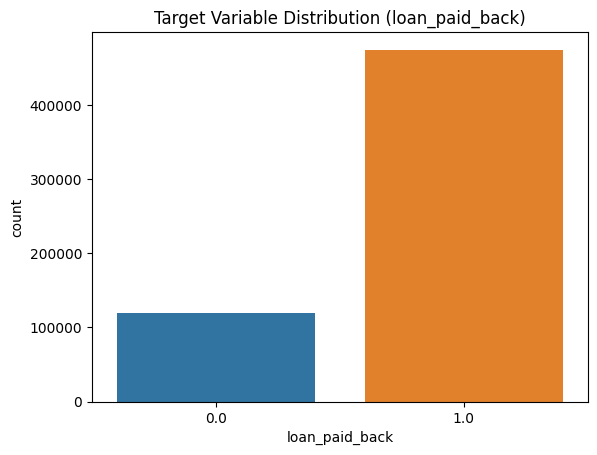

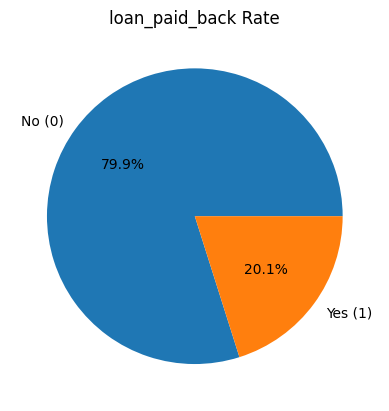

In [46]:
# Train
# Bar chart
sns.countplot(x='loan_paid_back', data=train_df)
plt.title("Target Variable Distribution (loan_paid_back)")
plt.show()

# Pie chart
train_df['loan_paid_back'].value_counts().plot.pie(autopct='%1.1f%%', labels=['No (0)','Yes (1)'])
plt.title("loan_paid_back Rate")
plt.ylabel("")
plt.show()


# Column lists for convenience

In [ ]:
# Identify numeric and categorical columns based on the actual dataset schema
num_cols = ["annual_income", "debt_to_income_ratio", "credit_score", "loan_amount", "interest_rate",
            "income_to_loan_ratio", "credit_score_to_dti", "loan_payment_burden", "disposable_income", "risk_score"]  # numerical features including engineered ones
cat_cols = ["gender", "marital_status", "education_level", "employment_status", "loan_purpose", "grade_subgrade"]  # categorical features

#  Univariate analysis: numerical features 

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


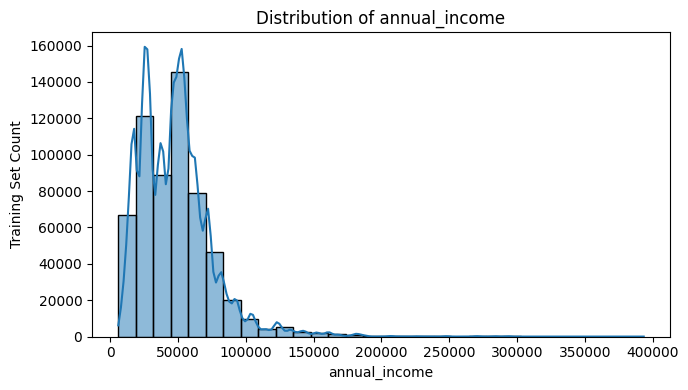

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


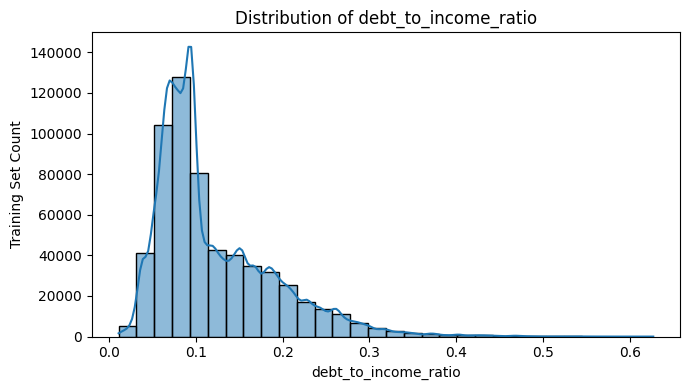

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


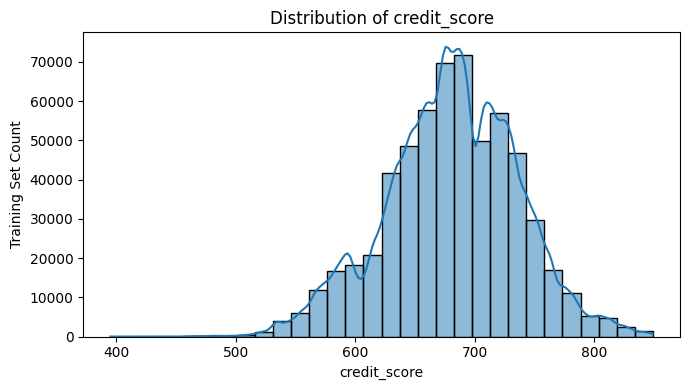

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


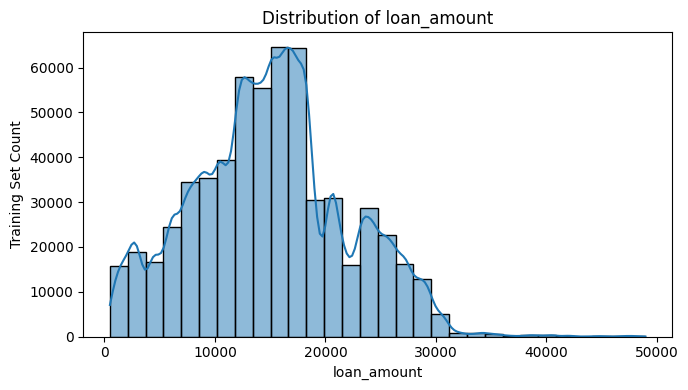

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


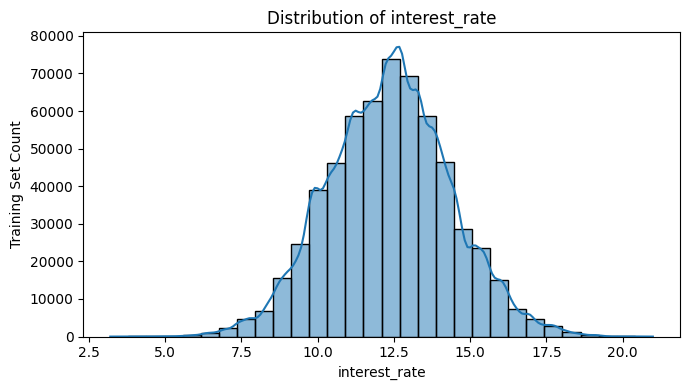

In [48]:
#train dataset
# Histograms + KDE to inspect distribution, skewness, and potential outliers
#Loops through each column in your list of numerical features (like age, balance, duration, etc.).
for col in num_cols:
    plt.figure(figsize=(7,4)) # Set figure size
    sns.histplot(train_df[col], bins=30, kde=True) # Histogram with density curve
    plt.title(f"Distribution of {col}") # Chart title
    plt.xlabel(col) # X axis label
    plt.ylabel("Training Set Count") # Y axis label
    plt.tight_layout() # Neat layout
    plt.show() # Render plot


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


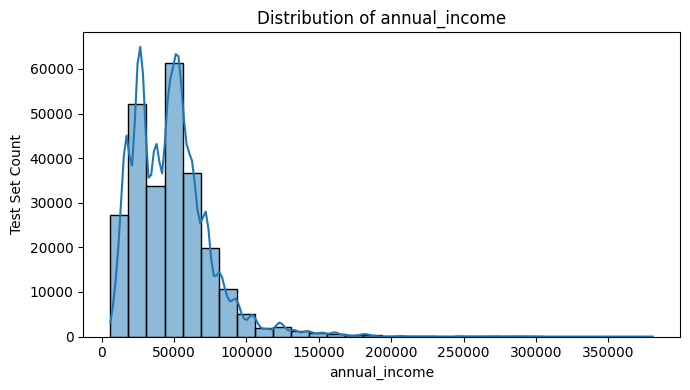

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


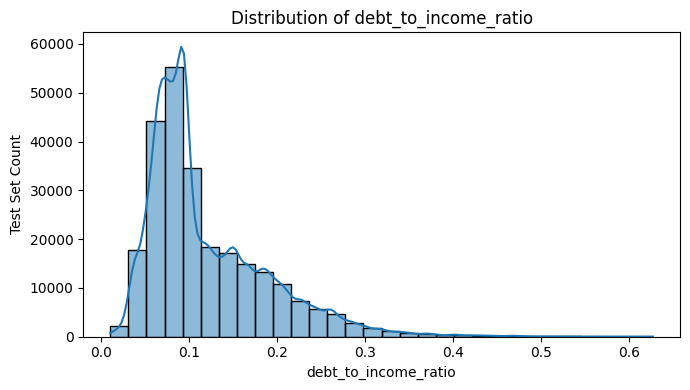

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


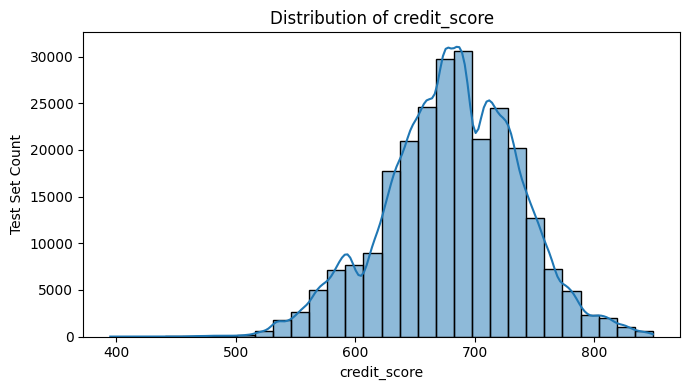

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


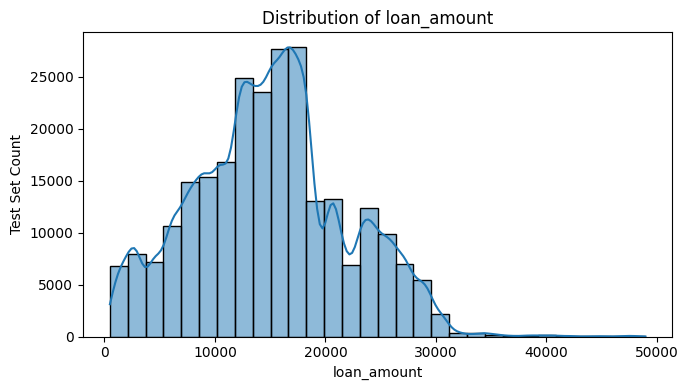

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


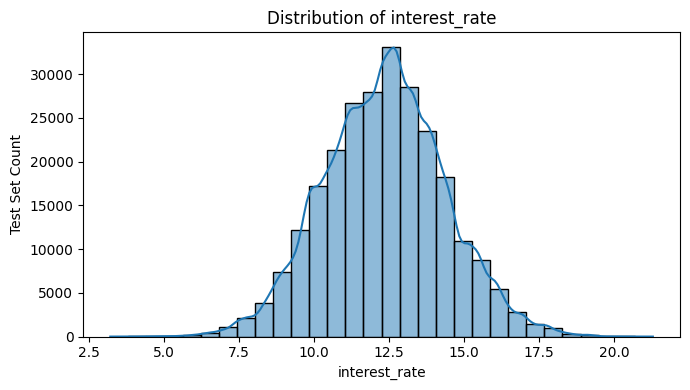

In [49]:
#test dataset
# Histograms + KDE to inspect distribution, skewness, and potential outliers
#Loops through each column in your list of numerical features (like age, balance, duration, etc.).
for col in num_cols:
    plt.figure(figsize=(7,4)) # Set figure size
    sns.histplot(test_df[col], bins=30, kde=True) # Histogram with density curve
    plt.title(f"Distribution of {col}") # Chart title
    plt.xlabel(col) # X axis label
    plt.ylabel("Test Set Count") # Y axis label
    plt.tight_layout() # Neat layout
    plt.show() # Render plot


#  Univariate analysis: categorical features 

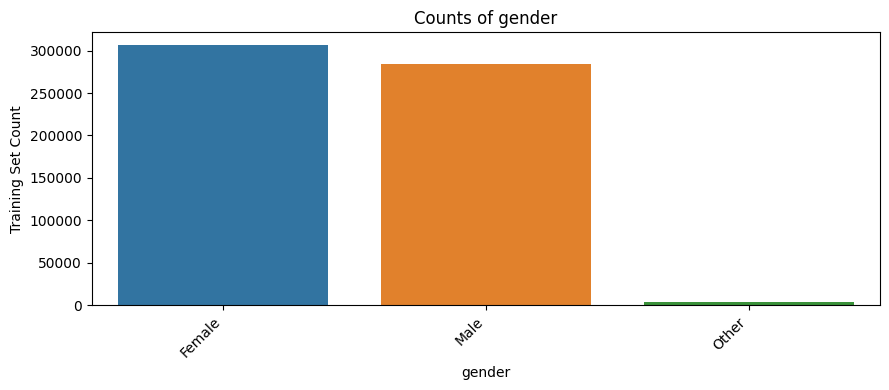

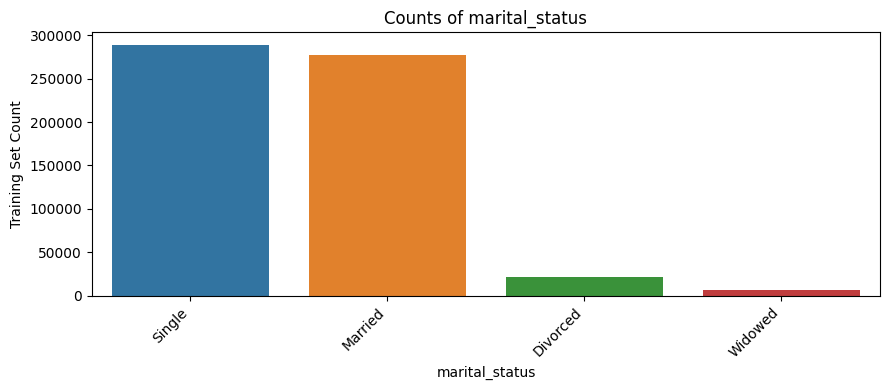

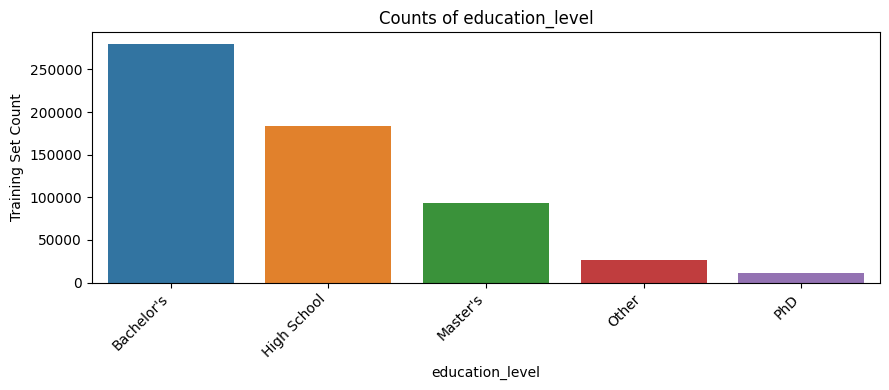

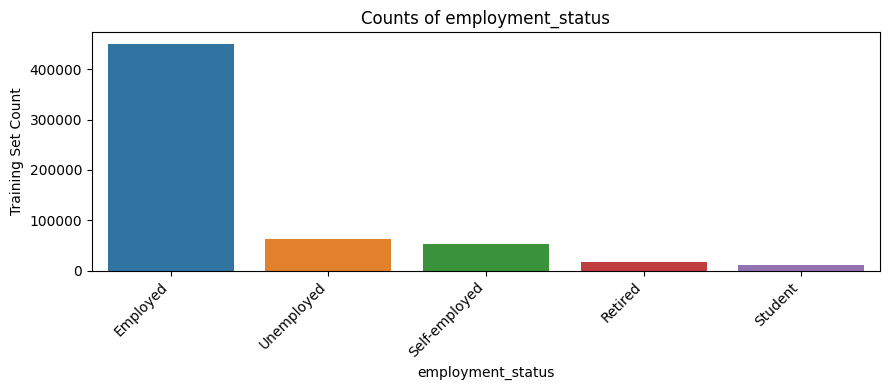

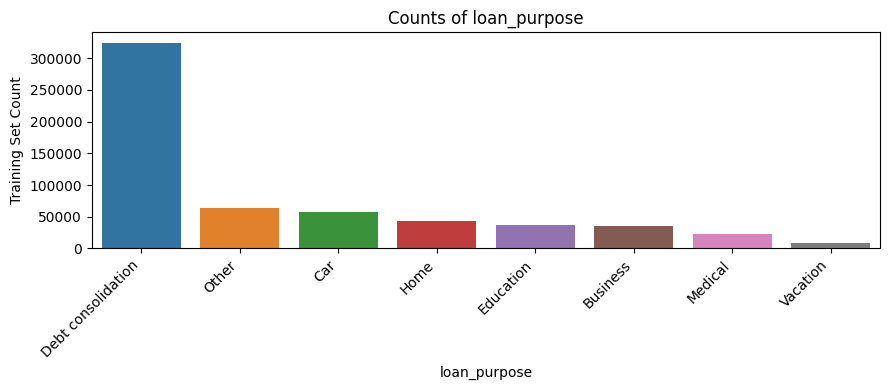

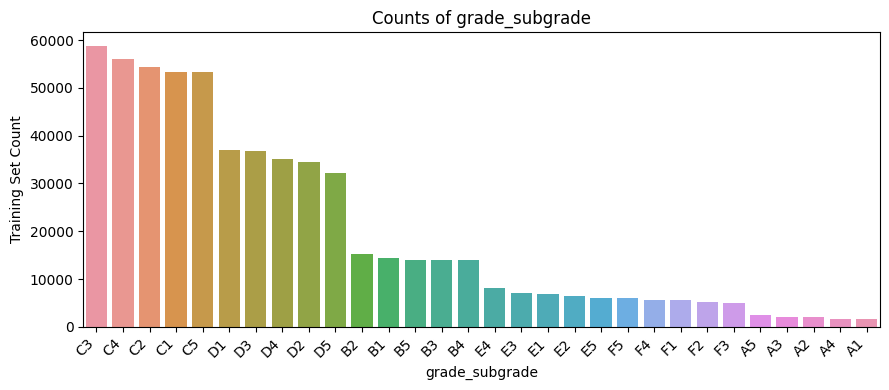

In [50]:
# train dataset
# Bar charts showing frequency of each category (ordered by count)
for col in cat_cols:
    plt.figure(figsize=(9,4)) # Set figure size
    order = train_df[col].value_counts().index # Order bars by frequency
    sns.countplot(data=train_df, x=col, order=order) # Bar plot of category counts
    plt.title(f"Counts of {col}") # Title
    plt.xlabel(col) # X label
    plt.ylabel("Training Set Count") # Y label
    plt.xticks(rotation=45, ha='right') # Rotate labels for readability
    plt.tight_layout() # Neat layout
    plt.show() # Render


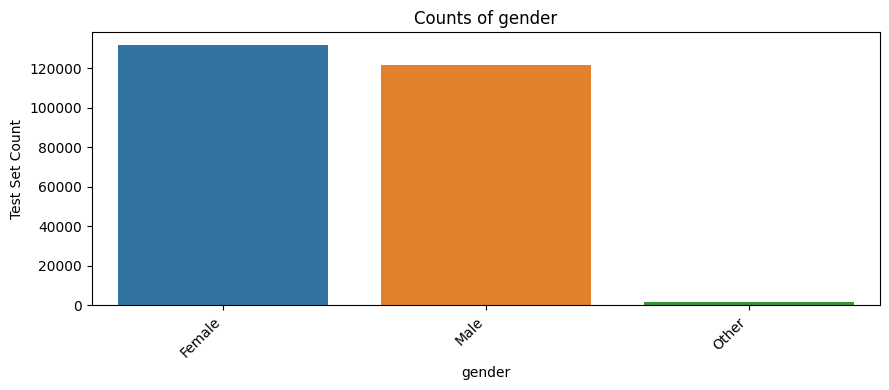

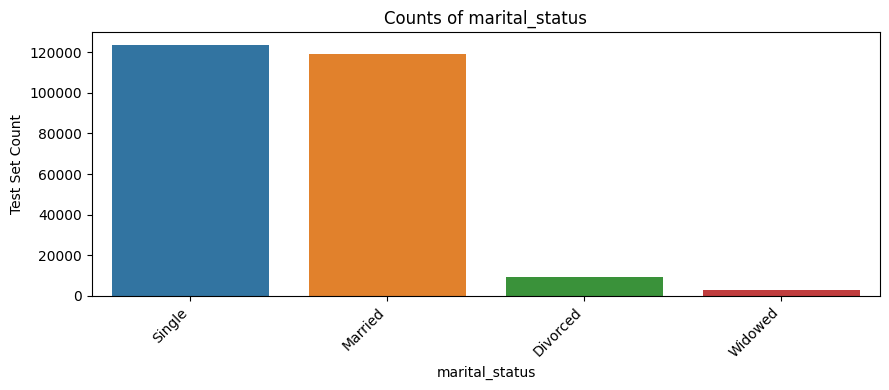

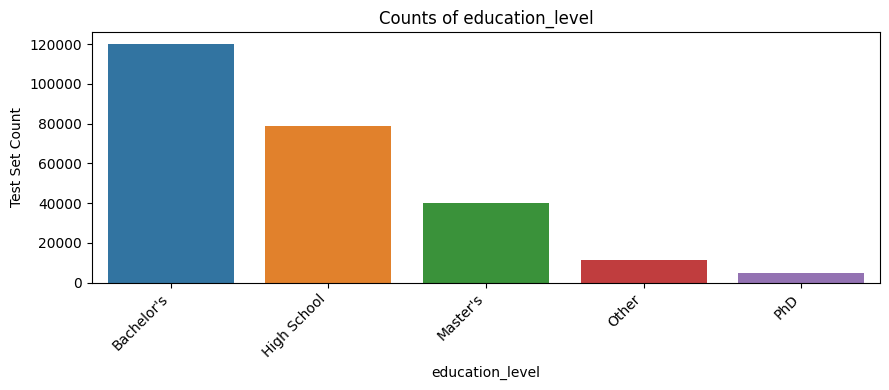

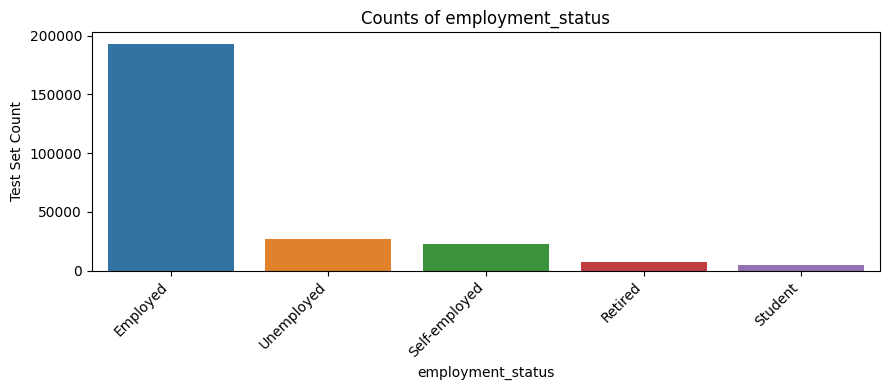

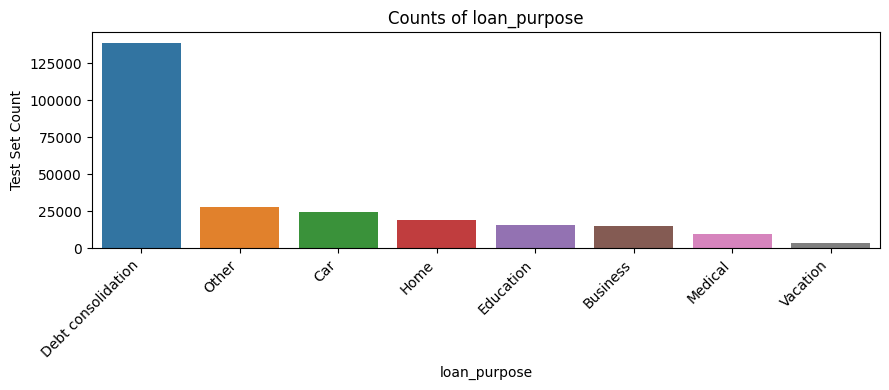

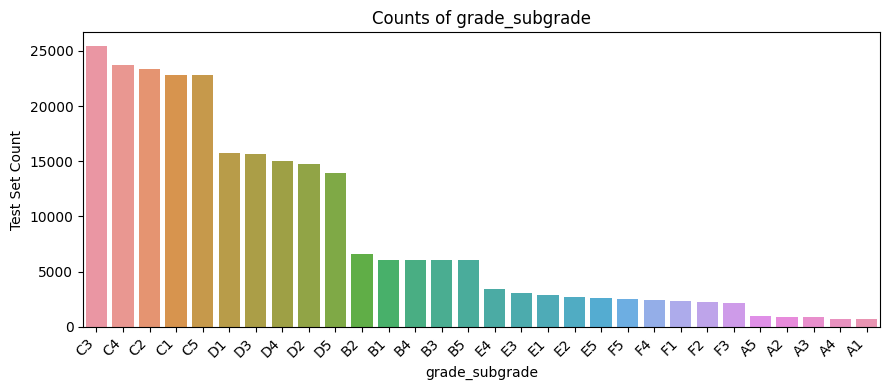

In [51]:
# test dataset
# Bar charts showing frequency of each category (ordered by count)
for col in cat_cols:
    plt.figure(figsize=(9,4)) # Set figure size
    order = test_df[col].value_counts().index # Order bars by frequency
    sns.countplot(data=test_df, x=col, order=order) # Bar plot of category counts
    plt.title(f"Counts of {col}") # Title
    plt.xlabel(col) # X label
    plt.ylabel("Test Set Count") # Y label
    plt.xticks(rotation=45, ha='right') # Rotate labels for readability
    plt.tight_layout() # Neat layout
    plt.show() # Render


#  Bivariate analysis: numeric vs target 

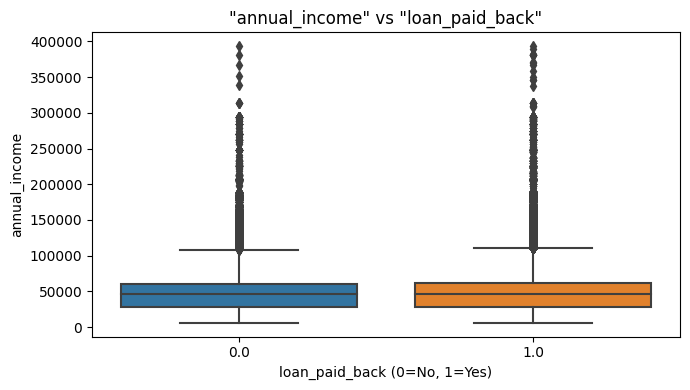

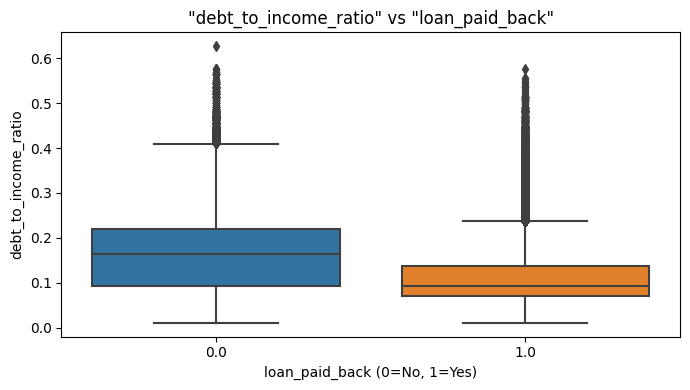

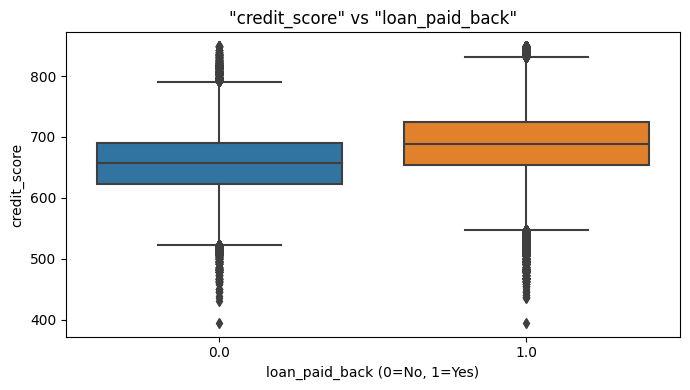

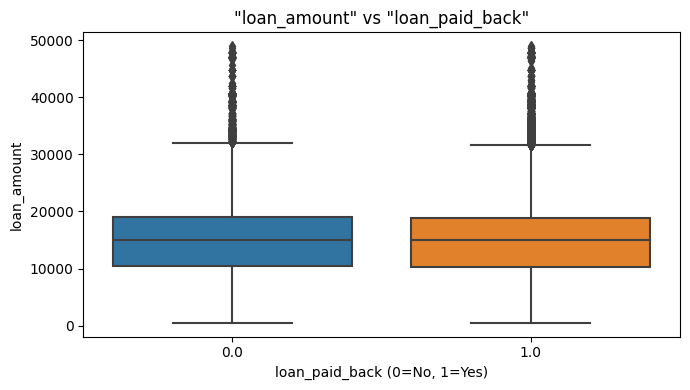

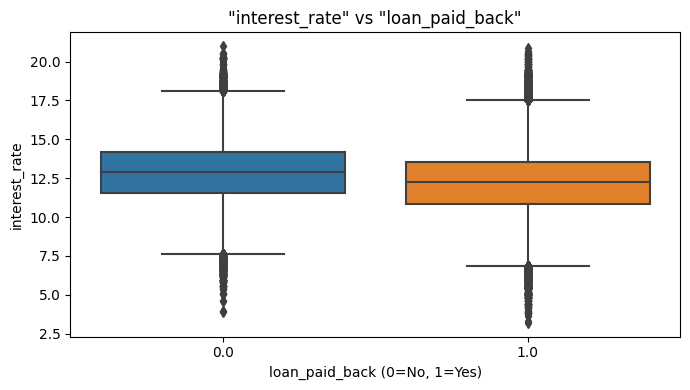

In [52]:
# Boxplots help visualize how numeric distributions differ by class loan_paid_back
for col in num_cols:
    plt.figure(figsize=(7,4)) # Figure size
    sns.boxplot(data=train_df, x='loan_paid_back', y=col) # Boxplot loan_paid_back~col by class
    plt.title(f'"{col}" vs "loan_paid_back"') # Title
    plt.xlabel("loan_paid_back (0=No, 1=Yes)") # X label
    plt.ylabel(col) # Y label
    plt.tight_layout() # Neat layout
    plt.show() # Render


#  Bivariate analysis: categorical vs target 

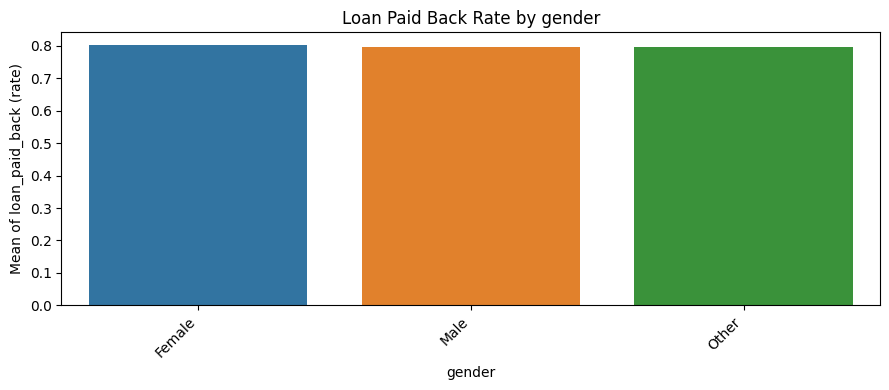

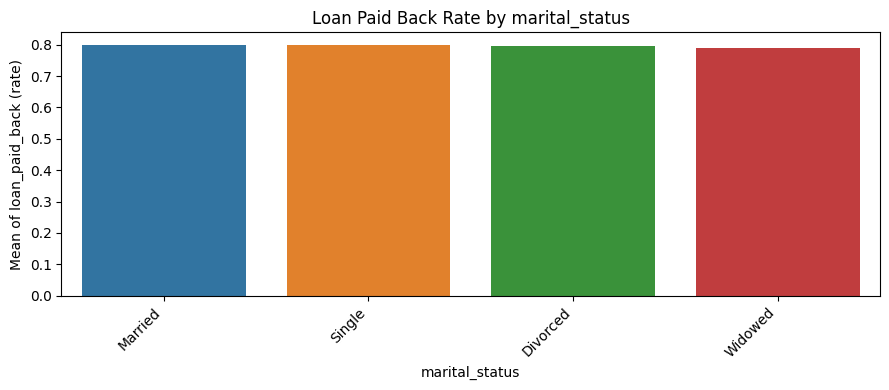

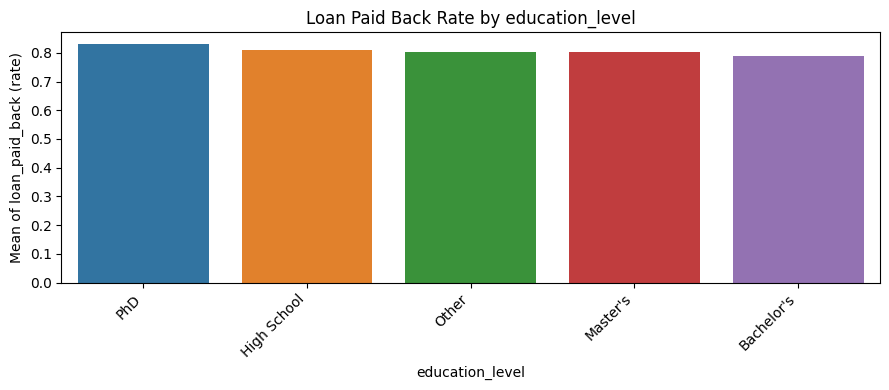

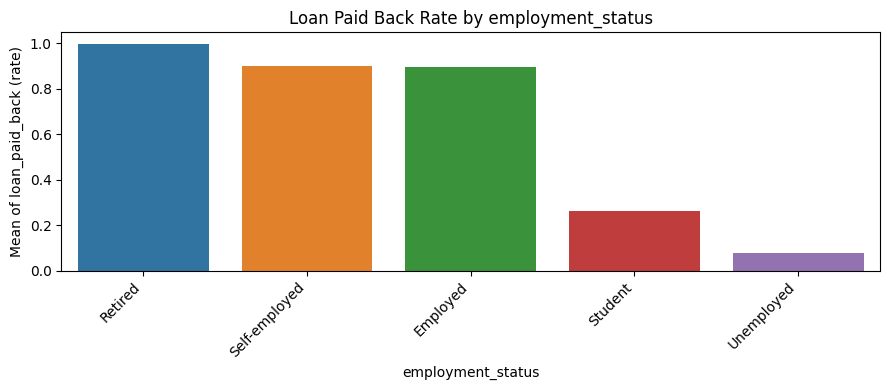

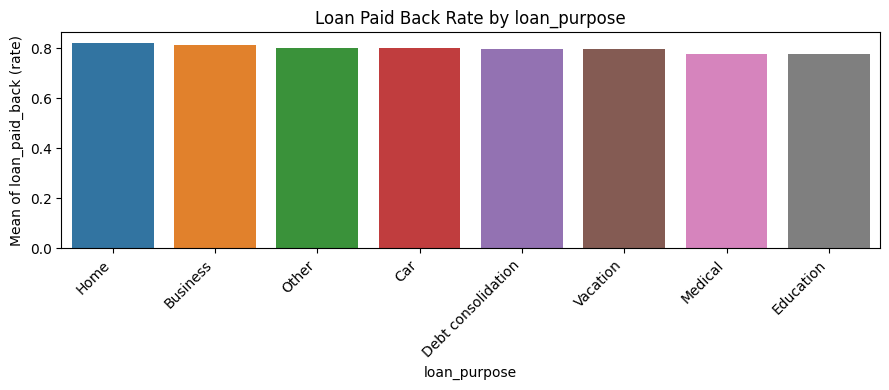

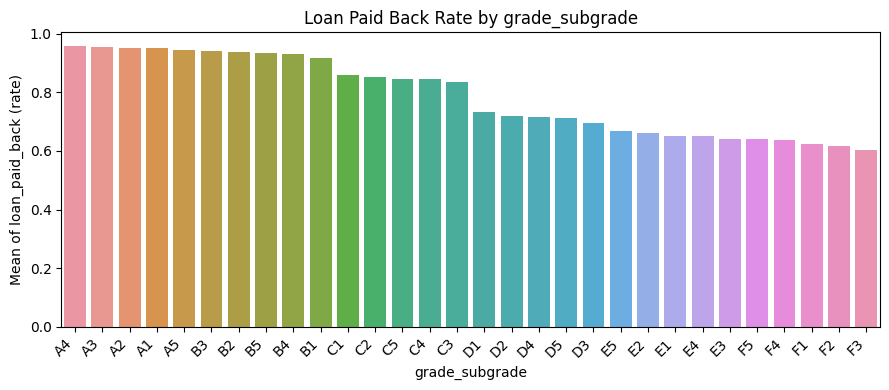

In [53]:
# Loan paid back rate (mean of loan_paid_back) per category for each categorical feature
for col in cat_cols:
# Compute mean target per category (i.e., conversion rate)
    rate = train_df.groupby(col)['loan_paid_back'].mean().sort_values(ascending=False)
    plt.figure(figsize=(9,4)) # Figure size
    sns.barplot(x=rate.index, y=rate.values) # Bar chart of rates
    plt.title(f"Loan Paid Back Rate by {col}") # Title
    plt.xlabel(col) # X label
    plt.ylabel("Mean of loan_paid_back (rate)") # Y label
    plt.xticks(rotation=45, ha='right') # Readable ticks
    plt.tight_layout() # Neat layout
    plt.show() # Render

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


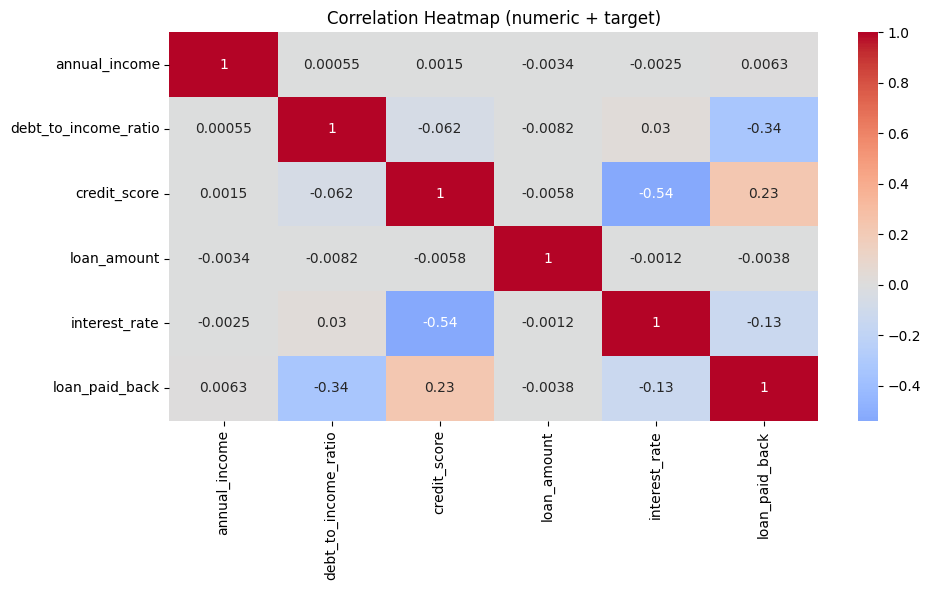

In [54]:
#Train Correlation analysis (numerical features only) ----
# Pearson correlations among numerical features and the target
corr = train_df[num_cols + ['loan_paid_back']].corr() # Compute correlation matrix
plt.figure(figsize=(10,6)) # Figure size
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0) # Heatmap with values
plt.title("Correlation Heatmap (numeric + target)") # Title
plt.tight_layout() # Neat layout
plt.show() # Render

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


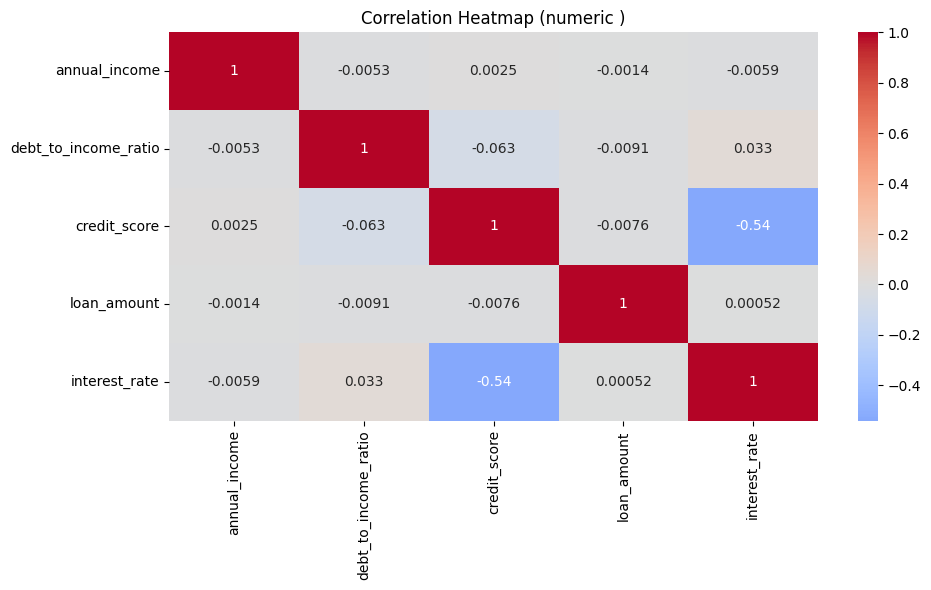

In [55]:
#Test Correlation analysis (numerical features only) ----
# Pearson correlations among numerical features and the target
corr = test_df[num_cols ].corr() # Compute correlation matrix
plt.figure(figsize=(10,6)) # Figure size
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0) # Heatmap with values
plt.title("Correlation Heatmap (numeric )") # Title
plt.tight_layout() # Neat layout
plt.show() # Render

In [56]:
#train data set 
# Store IQR outlier results in a DataFrame
iqr_outliers = []
for col in num_cols:
    q1, q3 = train_df[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower = q1 - 3 * iqr
    upper = q3 + 3 * iqr
    outliers = ((train_df[col] < lower) | (train_df[col] > upper)).sum()
    iqr_outliers.append([col, outliers, lower, upper])

train_outlier_df = pd.DataFrame(iqr_outliers, columns=["Column", "Outlier_Count", "Lower_Bound", "Upper_Bound"])
print(train_outlier_df)  

                 Column  Outlier_Count  Lower_Bound  Upper_Bound
0         annual_income           3282    -71206.36   160122.080
1  debt_to_income_ratio           1734        -0.18        0.408
2          credit_score              2       427.00      938.000
3           loan_amount            218    -15457.26    44595.460
4         interest_rate              0         2.92       21.750


In [57]:
#test data set
# Store IQR outlier results in a DataFrame
iqr_outliers = []
for col in num_cols:
    q1, q3 = test_df[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower = q1 - 3 * iqr
    upper = q3 + 3 * iqr
    outliers = ((test_df[col] < lower) | (test_df[col] > upper)).sum()
    iqr_outliers.append([col, outliers, lower, upper])

test_outlier_df = pd.DataFrame(iqr_outliers, columns=["Column", "Outlier_Count", "Lower_Bound", "Upper_Bound"])
print(test_outlier_df) 

                 Column  Outlier_Count  Lower_Bound  Upper_Bound
0         annual_income           1304    -71647.12   160746.860
1  debt_to_income_ratio            736        -0.18        0.408
2          credit_score              1       427.00      938.000
3           loan_amount            100    -15500.06    44580.100
4         interest_rate              0         2.85       21.820


# ***Encoding categorical variables***

In [58]:
#train data set 
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# 1. Get categorical columns automatically (object or category dtype)
cat_cols = train_df.select_dtypes(include=["object", "category"]).columns.tolist()
print("Categorical columns:", cat_cols)

# 2. Create encoder
encoder = OneHotEncoder(sparse=False, drop="first")

# 3. Fit + transform categorical data
encoded = encoder.fit_transform(train_df[cat_cols])

# 4. Get new column names
encoded_cols = encoder.get_feature_names_out(cat_cols)

# 5. Convert to dataframe
encoded_df = pd.DataFrame(encoded, columns=encoded_cols, index=train_df.index)

# 6. Drop original categorical columns and join new ones
train_encoded = train_df.drop(columns=cat_cols).join(encoded_df)

print(train_encoded.head())


Categorical columns: ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade']


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


   id  annual_income  debt_to_income_ratio  credit_score  loan_amount  \
0   0       29367.99                 0.084           736      2528.42   
1   1       22108.02                 0.166           636      4593.10   
2   2       49566.20                 0.097           694     17005.15   
3   3       46858.25                 0.065           533      4682.48   
4   4       25496.70                 0.053           665     12184.43   

   interest_rate  loan_paid_back  gender_Male  gender_Other  \
0          13.67             1.0          0.0           0.0   
1          12.92             0.0          1.0           0.0   
2           9.76             1.0          1.0           0.0   
3          16.10             1.0          0.0           0.0   
4          10.21             1.0          1.0           0.0   

   marital_status_Married  ...  grade_subgrade_E1  grade_subgrade_E2  \
0                     0.0  ...                0.0                0.0   
1                     1.0  ...        

In [59]:
train_encoded=train_encoded.drop("id", axis=1)

In [60]:
X=train_encoded

In [61]:
#test data encoding 
# step 2
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# 1. Get categorical columns automatically (object or category dtype)
cat_cols = test_df.select_dtypes(include=["object", "category"]).columns.tolist()
print("Categorical columns:", cat_cols)

# 2. Create encoder
encoder = OneHotEncoder(sparse=False, drop="first")

# 3. Fit + transform categorical data
encoded = encoder.fit_transform(test_df[cat_cols])

# 4. Get new column names
encoded_cols = encoder.get_feature_names_out(cat_cols)

# 5. Convert to dataframe
encoded_df = pd.DataFrame(encoded, columns=encoded_cols, index=test_df.index)

# 6. Drop original categorical columns and join new ones
test_encoded = test_df.drop(columns=cat_cols).join(encoded_df)

print(test_encoded.head())

Categorical columns: ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade']


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


       id  annual_income  debt_to_income_ratio  credit_score  loan_amount  \
0  593994       28781.05                 0.049           626     11461.42   
1  593995       46626.39                 0.093           732     15492.25   
2  593996       54954.89                 0.367           611      3796.41   
3  593997       25644.63                 0.110           671      6574.30   
4  593998       25169.64                 0.081           688     17696.89   

   interest_rate  gender_Male  gender_Other  marital_status_Married  \
0          14.73          0.0           0.0                     0.0   
1          12.85          0.0           0.0                     1.0   
2          13.29          1.0           0.0                     0.0   
3           9.57          0.0           0.0                     0.0   
4          12.80          0.0           0.0                     1.0   

   marital_status_Single  ...  grade_subgrade_E1  grade_subgrade_E2  \
0                    1.0  ...          

In [62]:
test_encoded=test_encoded.drop("id", axis=1)

In [63]:
# Combine train and test features for consistent scaling
train_features = train_encoded.drop(columns=["loan_paid_back"])
test_features = test_encoded
combined_features = pd.concat([train_features, test_features], ignore_index=True)

# Fit scaler on combined features
scaler = StandardScaler()
combined_scaled = scaler.fit_transform(combined_features)
combined_scaled_df = pd.DataFrame(combined_scaled, columns=combined_features.columns)

# Split back
X = combined_scaled_df.iloc[:len(train_features)]
X_test = combined_scaled_df.iloc[len(train_features):]

# ****Train/Validation Split****

In [64]:
#: Separate features & target ---
y = train_encoded["loan_paid_back"]

print(X.shape, y.shape)

(593994, 54) (593994,)


In [65]:
from sklearn.model_selection import train_test_split
#Train
# X and y already prepared from your train dataset
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, y_train.shape)
print("Validation shape:", X_val.shape, y_val.shape)

Train shape: (475195, 54) (475195,)
Validation shape: (118799, 54) (118799,)


In [66]:
#Test
# X and y already prepared from your train dataset
#X_test, X_val, y_test, y_val = train_test_split(
#    X, y, test_size=0.2, random_state=42, stratify=y
#)

#print("Train shape:", X_test.shape, y_test.shape)
#print("Validation shape:", X_val.shape, y_val.shape)

# ****Models Evaluation****

In [67]:
#from sklearn.utils import class_weight

# use your actual target variable 'y'
#weights = class_weight.compute_class_weight(
 #   class_weight='balanced',
  #  classes=np.unique(y),
   # y=y
#)

#print("Class Weights:", dict(zip(np.unique(y), weights)))


In [68]:
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, roc_auc_score

# Use class weights from earlier
#class_weights = [weights[0], weights[1]]

cat_model = CatBoostClassifier(iterations=2000,learning_rate=0.05,depth=8,l2_leaf_reg=5,random_seed=42,eval_metric="AUC",verbose=200)
#class_weights=class_weights,
# Train
cat_model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)

# Predictions (probabilities for AUC)
cat_pred_proba = cat_model.predict_proba(X_val)[:, 1]
cat_pred = cat_model.predict(X_val)

# Metrics
print("ROC AUC Score (CatBoost):", roc_auc_score(y_val, cat_pred_proba))
print("F1 Score (CatBoost):", f1_score(y_val, cat_pred))


0:	test: 0.8999515	best: 0.8999515 (0)	total: 77ms	remaining: 2m 34s
200:	test: 0.9165125	best: 0.9165125 (200)	total: 17s	remaining: 2m 32s
400:	test: 0.9189237	best: 0.9189237 (400)	total: 32.5s	remaining: 2m 9s
600:	test: 0.9202911	best: 0.9202911 (600)	total: 48s	remaining: 1m 51s
800:	test: 0.9209476	best: 0.9209476 (800)	total: 1m 3s	remaining: 1m 35s
1000:	test: 0.9214328	best: 0.9214328 (1000)	total: 1m 19s	remaining: 1m 19s
1200:	test: 0.9218603	best: 0.9218603 (1200)	total: 1m 35s	remaining: 1m 3s
1400:	test: 0.9220772	best: 0.9220808 (1399)	total: 1m 51s	remaining: 47.6s
1600:	test: 0.9221845	best: 0.9221961 (1566)	total: 2m 7s	remaining: 31.7s
1800:	test: 0.9222651	best: 0.9222727 (1785)	total: 2m 22s	remaining: 15.8s
1999:	test: 0.9223402	best: 0.9223439 (1985)	total: 2m 38s	remaining: 0us

bestTest = 0.922343919
bestIteration = 1985

Shrink model to first 1986 iterations.
ROC AUC Score (CatBoost): 0.9223439189543994
F1 Score (CatBoost): 0.9430960429003482


In [69]:
y_pred_proba = cat_model.predict_proba(X_test)[:, 1]

In [70]:
submission=pd.DataFrame({'id':test_df['id'], 'loan_paid_back':y_pred_proba})
print(submission)

            id  loan_paid_back
0       593994        0.941522
1       593995        0.978545
2       593996        0.356698
3       593997        0.924864
4       593998        0.967737
...        ...             ...
254564  848558        0.993910
254565  848559        0.794875
254566  848560        0.972643
254567  848561        0.987092
254568  848562        0.893735

[254569 rows x 2 columns]


In [71]:
submission.to_csv('submission_cat.csv',index=False)